In [14]:
pip install vit_pytorch linformer

In [15]:
from __future__ import print_function

import glob
from itertools import chain
import os
import random
import zipfile

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from linformer import Linformer
from PIL import Image
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from tqdm.notebook import tqdm

from vit_pytorch.efficient import ViT

In [27]:
import pandas as pd

# importing modules
import urllib.request
from PIL import Image
import requests
data = pd.read_csv(
    "/content/drive/MyDrive/GBooksAPI_JSONtoPandas_withImages_20210524.csv",
    sep="\t", header=0)
#data = data.to_numpy()
data.head()




,title,authors,language,description,previewLink,smallThumbnail,bigThumbnail
0,Princess Poppy: The Big Mix Up,['Janey Louise Jones'],en,A brand-new story in the best-selling Princess...,http://books.google.de/books?id=WY6VX4O2_7UC&p...,http://books.google.com/books/content?id=WY6VX...,http://books.google.com/books/content?id=WY6VX...
1,Einfach zeichnen! Step by Step,NOT_FOUND,de,NOT_FOUND,http://books.google.de/books?id=d2nlzQEACAAJ&d...,NOT_FOUND,NOT_FOUND
2,Red Queen,['Victoria Aveyard'],en,The first novel in the #1 bestselling RED QUEE...,http://books.google.de/books?id=EPO9BQAAQBAJ&p...,http://books.google.com/books/content?id=EPO9B...,http://books.google.com/books/content?id=EPO9B...
3,Meine Kindergartenfreunde,['Bianka Nadja Goylmonil'],de,Ein wunderschönes Freundebuch zur Erinnerung a...,http://books.google.de/books?id=9EUDzgEACAAJ&d...,NOT_FOUND,NOT_FOUND
4,Ewig geliebt,['J. R. Ward'],de,Rhage und Mary sind Geliebte und Seelenverwand...,http://books.google.de/books?id=O4c2DAAAQBAJ&p...,http://books.google.com/books/content?id=O4c2D...,http://books.google.com/books/content?id=O4c2D...


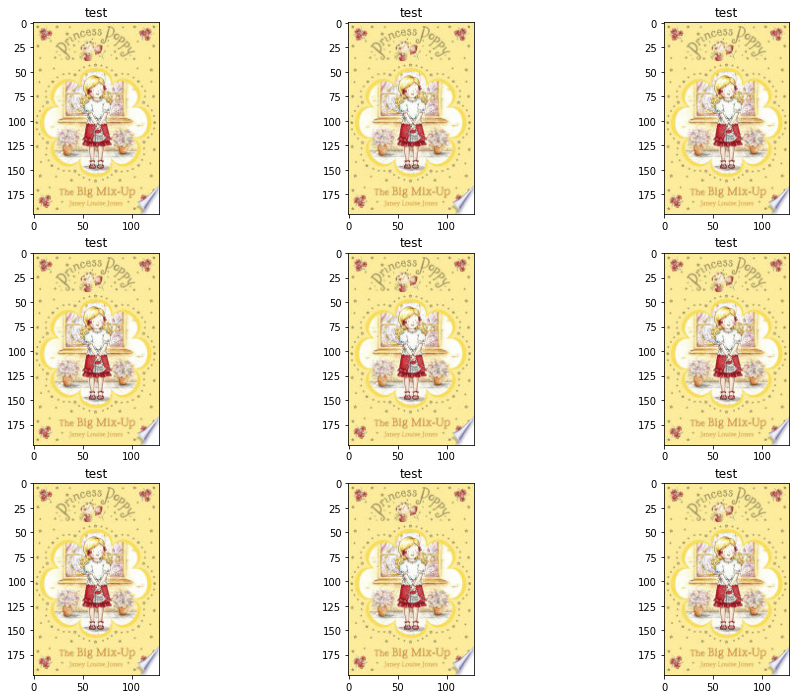

In [26]:
im = Image.open(requests.get(data["bigThumbnail"][0], stream=True).raw)
fig, axes = plt.subplots(3, 3, figsize=(16, 12))
for idx, ax in enumerate(axes.ravel()):
    ax.set_title("test")
    ax.imshow(im)

In [43]:
items=pd.read_csv("/content/items.csv", sep="|")
items.isna().sum()

itemID           0
title            0
author        3240
publisher        9
main topic     258
subtopics        1
dtype: int64

In [35]:
items.head()

,itemID,title,author,publisher,main topic,subtopics
0,21310,Princess Poppy: The Big Mix Up,Janey Louise Jones,Penguin Random House Children's UK,YFB,[5AH]
1,73018,Einfach zeichnen! Step by Step,Wiebke Krabbe,Schwager und Steinlein,AGZ,"[5AJ,AGZ,WFA,YBG,YBL,YNA,YPA]"
2,19194,Red Queen 1,Victoria Aveyard,Orion Publishing Group,YFH,"[5AP,FBA]"
3,40250,Meine Kindergarten-Freunde (Pirat),NaN,Ars Edition GmbH,YB,"[5AC,5AD,YBG,YBL,YF]"
4,46107,Mein großes Schablonen-Buch - Wilde Tiere,Elizabeth Golding,Edition Michael Fischer,WFTM,"[WD,WFTM,YBG,YBL,YBLD,YBLN1]"


In [36]:
len(items)

78030

In [32]:
items['main topic'] = items['main topic'].fillna("no_main_topic")
items.isna().sum()

itemID           0
title            0
author        3240
publisher        9
main topic       0
subtopics        1
dtype: int64

In [34]:
print(len(data))
data = data[data['bigThumbnail'] != "NOT_FOUND"]
print(len(data))

72217
67320


In [44]:
items = items.drop(['itemID', 'author',	'publisher', 'subtopics'], axis=1)
items.head()

,title,main topic
0,Princess Poppy: The Big Mix Up,YFB
1,Einfach zeichnen! Step by Step,AGZ
2,Red Queen 1,YFH
3,Meine Kindergarten-Freunde (Pirat),YB
4,Mein großes Schablonen-Buch - Wilde Tiere,WFTM


In [45]:
data = data.drop(['authors',	'language',	'description',	'previewLink',	'smallThumbnail'], axis=1)
data.head()

,title,bigThumbnail
0,Princess Poppy: The Big Mix Up,http://books.google.com/books/content?id=WY6VX...
2,Red Queen,http://books.google.com/books/content?id=EPO9B...
4,Ewig geliebt,http://books.google.com/books/content?id=O4c2D...
5,Meine Sticker-Tiere,http://books.google.com/books/content?id=bSM9t...
6,Unsterblich - Tor der Dämmerung,http://books.google.com/books/content?id=sskVj...


In [54]:
joined_dfs = items.merge(data, how='inner', on='title')
joined_dfs

,title,main topic,bigThumbnail
0,Princess Poppy: The Big Mix Up,YFB,http://books.google.com/books/content?id=WY6VX...
1,Ewig geliebt,FMR,http://books.google.com/books/content?id=O4c2D...
2,Meine Sticker-Tiere,YBG,http://books.google.com/books/content?id=bSM9t...
3,Unsterblich 01 - Tor der Dämmerung,YFE,http://books.google.com/books/content?id=t1-vN...
4,Pedro und die Bettler von Cartagena,YFB,http://books.google.com/books/content?id=1wuYS...
...,...,...,...
65675,Timeless Fairy Tales,YFA,http://books.google.com/books/content?id=Iwr_Q...
65676,Demon Games,FMB,http://books.google.com/books/content?id=V6jZo...
65677,Lori and the Lion's Den,YFU,http://books.google.com/books/content?id=SLuIo...
65678,The Everywhere Armchair,YFC,http://books.google.com/books/content?id=f4RFW...


In [5]:
#UTILITIES
#Convert list strings into Python lists

#Search function for detecting empty strings (returns true if found)
def search(list, platform):
    for i in range(len(list)):
        if list[i] == platform:
            return True
    return False

#Function to convert "pseudo-lists" (lists which are in string format), into Python list
def convert_string_to_list(input_string):
    if pd.isnull(input_string)==False:
        record_string = input_string.replace("'","").replace('"','').replace('[','').replace(']','')
        record_list = record_string.split(',')

        #get rid of whitespaces
        record_list = [r.strip() for r in record_list]

        #Remove empty strings from list
        while search(record_list, ''):
            record_list.remove('')

        return record_list
    else:
        return []

#Separate publishing data

def get_publishing_year(input_string):
    by = input_string.find('by')
    return input_string[by-5:by-1]

def get_publishing_name(input_string):
    by = input_string.find('by')
    fp = input_string.find('first published')

    if fp==-1:
        return input_string[by+3:len(input_string)]
    else:
        return input_string[by+3:fp-1]

def get_first_published(input_string):
    fp = input_string.find('first published')

    if fp==-1:
        return ''
    else:
        return input_string[len(input_string)-5:len(input_string)-1]

In [4]:
kaggle = pd.read_csv("/content/kaggle.csv", index_col=0)
kaggle = kaggle.drop(columns=['user_id','location','age','rating','img_s','img_m','img_l','city','state','country']).drop_duplicates()
kaggle = kaggle.replace('9',np.nan)
kaggle.columns=['gb_isbn','gb_title', 'gb_author', 'gb_pub_year', 'gb_publisher', 'gb_description', 'gb_language', 'gb_genres']

kaggle['gb_genres'] = kaggle['gb_genres'].astype('string').apply(convert_string_to_list)
kaggle['gb_author'] = kaggle['gb_author'].astype('string').apply(convert_string_to_list)

ParserError: ignored

In [ ]:
# Training settings
batch_size = 64
epochs = 20
lr = 3e-5
gamma = 0.7
seed = 42

In [ ]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(seed)

In [ ]:
device = 'cuda'

Data Loading Process

In [ ]:
# Creat image list
meta_data = pd.read_csv(
    "/content/drive/MyDrive/CV_project/data/metadata.csv",
    sep=",", header=0)
meta_data = meta_data.to_numpy()
meta_data = meta_data[meta_data[:,4]!="RGB",:]
list_of_images =[]
for filepath in meta_data:
  list_of_images.append("/content/drive/MyDrive/CV_project/data/COVID-19_Radiography_Dataset/COVID-19_Radiography_Dataset/" + filepath[5] + "/" + filepath[1])
print("Number of Images:", len(list_of_images))

Number of Images: 21025


In [ ]:
# Add labels to the list
labels = [path.split('/')[-1].split('.')[0].split('-')[0] for path in list_of_images]
print("COVID: ", labels.count('COVID'))
print("Lung Opacity: ",labels.count('Lung_Opacity'))
print("Normal: ",labels.count('Normal'))
print("Viral Pneumonia: ",labels.count('Viral Pneumonia'))

COVID:  3616
Lung Opacity:  6012
Normal:  10192
Viral Pneumonia:  1205


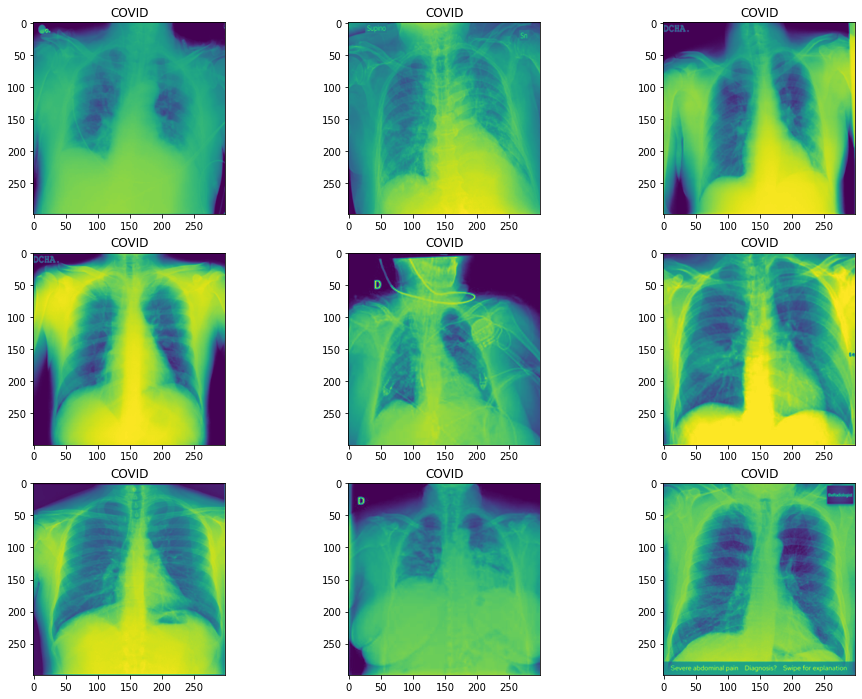

In [ ]:
random_idx = np.random.randint(1, len(list_of_images), size=9)
fig, axes = plt.subplots(3, 3, figsize=(16, 12))

for idx, ax in enumerate(axes.ravel()):
    img = Image.open(list_of_images[idx])
    ax.set_title(labels[idx])
    ax.imshow(img)

In [ ]:
# Split in Training, Validation and Test
train_list, test_list = train_test_split(list_of_images, 
                                          test_size=0.1,
                                          stratify=labels,
                                          random_state=seed)
labels_training = [path.split('/')[-1].split('.')[0].split('-')[0] for path in train_list]
train_list, valid_list = train_test_split(train_list, 
                                          test_size=0.1,
                                          stratify=labels_training,
                                          random_state=seed)

In [ ]:
print(f"Train Data: {len(train_list)}")
print(f"Validation Data: {len(valid_list)}")
print(f"Test Data: {len(test_list)}")

Train Data: 17029
Validation Data: 1893
Test Data: 2103


Image Augumentation

In [ ]:
train_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]
)

val_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]
)


test_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]
)

Loading Datasets


In [ ]:
class CovidDataset(Dataset):
    def __init__(self, file_list, transform=None):
        self.file_list = file_list
        self.transform = transform

    def __len__(self):
        self.filelength = len(self.file_list)
        return self.filelength

    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        img_transformed = self.transform(img)

        label_word = img_path.split("/")[-1].split(".")[0].split('-')[0]
        if label_word == "COVID":
          label = 0
        elif label_word == "Lung_Opacity":
          label = 1
        elif label_word == "Lung_Opacity":
          label = 2
        else:
          label = 3

        return img_transformed, label

In [ ]:
train_data = CovidDataset(train_list, transform=train_transforms)
valid_data = CovidDataset(valid_list, transform=test_transforms)
test_data = CovidDataset(test_list, transform=test_transforms)

In [ ]:
train_loader = DataLoader(dataset = train_data, batch_size=batch_size, shuffle=True )
valid_loader = DataLoader(dataset = valid_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset = test_data, batch_size=batch_size, shuffle=True)

In [ ]:
print(len(train_data), len(train_loader))

17029 267


In [ ]:
print(len(valid_data), len(valid_loader))

1893 30


**Effecient Attention**

Lineformer


In [ ]:

efficient_transformer = Linformer(
    dim=128,
    seq_len=49+1,  # 7x7 patches + 1 cls-token
    depth=12,
    heads=8,
    k=64
)

In [ ]:
model = ViT(
    dim=128,
    image_size=224,
    patch_size=32,
    num_classes=4,
    transformer=efficient_transformer,
    channels=1,
).to(device)

Training

In [ ]:
# loss function
criterion = nn.CrossEntropyLoss()
# optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)
# scheduler
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

In [ ]:
for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0

    for data, label in tqdm(train_loader):
        data = data.to(device)
        label = label.to(device)

        output = model(data)
        loss = criterion(output, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        acc = (output.argmax(dim=1) == label).float().mean()
        epoch_accuracy += acc / len(train_loader)
        epoch_loss += loss / len(train_loader)

    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for data, label in valid_loader:
            data = data.to(device)
            label = label.to(device)

            val_output = model(data)
            val_loss = criterion(val_output, label)

            acc = (val_output.argmax(dim=1) == label).float().mean()
            epoch_val_accuracy += acc / len(valid_loader)
            epoch_val_loss += val_loss / len(valid_loader)

    print(
        f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
    )


Epoch : 1 - loss : 1.0028 - acc: 0.5410 - val_loss : 0.9908 - val_acc: 0.5420




Epoch : 2 - loss : 0.9735 - acc: 0.5441 - val_loss : 0.9597 - val_acc: 0.5543




Epoch : 3 - loss : 0.9438 - acc: 0.5570 - val_loss : 0.9609 - val_acc: 0.5726




Epoch : 4 - loss : 0.9088 - acc: 0.5893 - val_loss : 0.8816 - val_acc: 0.6115




Epoch : 5 - loss : 0.8668 - acc: 0.6194 - val_loss : 0.8683 - val_acc: 0.6179




Epoch : 6 - loss : 0.8240 - acc: 0.6453 - val_loss : 0.8097 - val_acc: 0.6653




Epoch : 7 - loss : 0.7966 - acc: 0.6618 - val_loss : 0.8132 - val_acc: 0.6540




Epoch : 8 - loss : 0.7883 - acc: 0.6652 - val_loss : 0.7903 - val_acc: 0.6699




Epoch : 9 - loss : 0.7667 - acc: 0.6783 - val_loss : 0.7822 - val_acc: 0.6849




Epoch : 10 - loss : 0.7607 - acc: 0.6792 - val_loss : 0.7872 - val_acc: 0.6646




Epoch : 11 - loss : 0.7554 - acc: 0.6828 - val_loss : 0.7395 - val_acc: 0.6867




Epoch : 12 - loss : 0.7397 - acc: 0.6879 - val_loss : 0.7569 - val_acc: 0.6835




Epoch : 13 - loss : 0.7347 - acc: 0.6905 - val_loss : 0.7563 - val_acc: 0.6760




Epoch : 14 - loss : 0.7308 - acc: 0.6904 - val_loss : 0.7582 - val_acc: 0.6796




Epoch : 15 - loss : 0.7247 - acc: 0.6981 - val_loss : 0.7295 - val_acc: 0.6949




Epoch : 16 - loss : 0.7214 - acc: 0.6964 - val_loss : 0.7380 - val_acc: 0.6961




Epoch : 17 - loss : 0.7082 - acc: 0.7052 - val_loss : 0.7231 - val_acc: 0.7029




Epoch : 18 - loss : 0.7083 - acc: 0.7083 - val_loss : 0.7293 - val_acc: 0.7004




Epoch : 19 - loss : 0.7026 - acc: 0.7056 - val_loss : 0.7526 - val_acc: 0.6853




Epoch : 20 - loss : 0.6994 - acc: 0.7131 - val_loss : 0.7112 - val_acc: 0.7165

